# 6. Diagnóstico de supuestos

## 6.1 Importación de librerías de Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.robust.norms import HuberT

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 6.2 Cargue de modelos y matrices de Numpy

In [3]:
path = '../Data/'

X = np.load(path + 'X_def.dat', allow_pickle= True)
B = np.load(path + 'B_def.dat', allow_pickle= True)
Y = np.load(path + 'Y_def.dat', allow_pickle= True)

In [4]:
result =  sm.load(path + 'ols_def_results.pickle')

In [5]:
with open("../Data/regressor_columns_def.pickle", "rb") as fp:   #Pickling
...   regressor_columns_def = pickle.load(fp)

In [33]:
df = pd.read_csv(path+'Ames-Housing-regressor-columns.csv', delimiter=',')
df_original = pd.read_csv(path+'AmesHousing.csv', delimiter=',')

## 6.3 Validación supuesto de linealidad

Validamos el supuesto de linealidad de forma gráfica con el método de 'Residual vs Fitted' (**Figura 6.1**). Aquí buscamos que no se observe ninguna correlación entre los residuos y los valores predichos por el modelo. En nuestro modelo esta asunción parece cumplirse con éxito, dado que la dispersión de los residuos es aleatoria y el coeficiente de correlación calculado es prácticamente 0. 

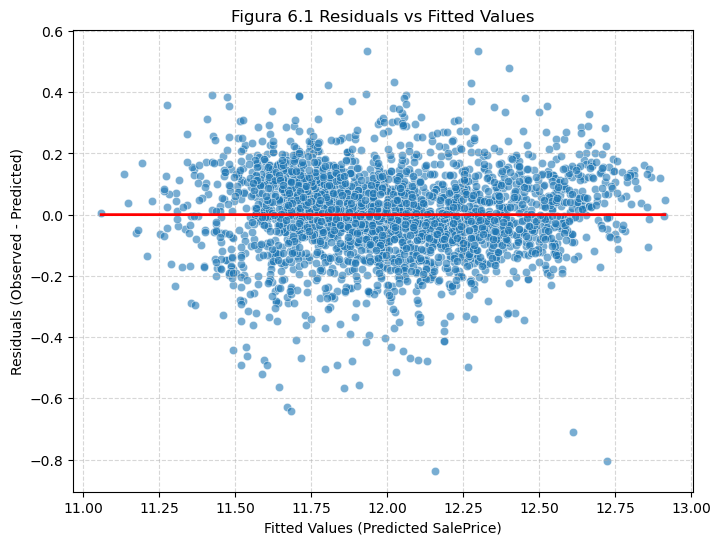

Correlation between fitted values and residuals: 0.0000
Linearity assumption seems reasonable (residuals uncorrelated with fitted values).


In [7]:
# Se obtienen los valores predichos y los residuos
fitted_vals = result.fittedvalues
residuals = result.resid

# 2. Grafica residuo vs predichos

plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
sns.lineplot(x=fitted_vals, y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Figura 6.1 Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predicted SalePrice)')
plt.ylabel('Residuals (Observed - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Validación estadística
corr = np.corrcoef(fitted_vals, residuals)[0,1]
print(f"Correlation between fitted values and residuals: {corr:.4f}")
if abs(corr) > 0.1:
    print("Possible non-linearity detected (residuals correlated with fitted values).")
else:
    print("Linearity assumption seems reasonable (residuals uncorrelated with fitted values).")

## 6.4 Validación de Homocedasticidad

Validamos homocedasticidad, que es la asunción que la varianza de los errores permanece constante para todas las observaciones, para esto nos apoyamos nuevamente del gráfico de Residuos vs Valores ajustados (**Figura 6.2**) y, adicionalmente, usamos el test de Breusch-Pagan y el de White, obteniendo los sigguientes resultados:

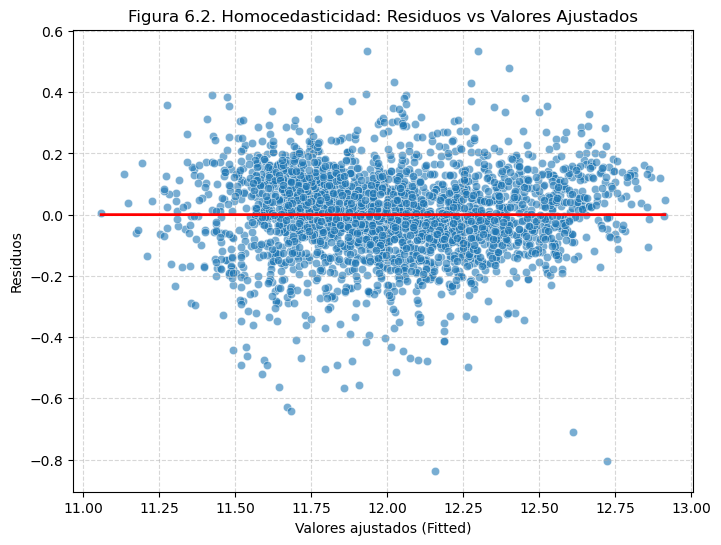


🔹 Resultados Test de Breusch–Pagan:
Lagrange multiplier statistic: 128.08584
LM-Test p-value: 0.00000
f-value: 11.13426
f p-value: 0.00000
Evidencia de heterocedasticidad (p < 0.05)

🔹 Resultados Test de White:
LM Statistic: 265.72276
LM p-value: 0.00000
F-Statistic: 3.34820
F p-value: 0.00000
Evidencia de heterocedasticidad según White (p < 0.05)


In [8]:
# Visualización: Residuos vs Valores ajustados
plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
sns.lineplot(x=fitted_vals, y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Figura 6.2. Homocedasticidad: Residuos vs Valores Ajustados')
plt.xlabel('Valores ajustados (Fitted)')
plt.ylabel('Residuos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Test de Breusch–Pagan
bp_test = het_breuschpagan(residuals, result.model.exog)

bp_labels = ['Lagrange multiplier statistic', 'LM-Test p-value', 
             'f-value', 'f p-value']
print("\n🔹 Resultados Test de Breusch–Pagan:")
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.5f}")

if bp_test[1] < 0.05:
    print("Evidencia de heterocedasticidad (p < 0.05)")
else:
    print("No se detecta heterocedasticidad significativa")
    
# Test de White
white_test = het_white(residuals, result.model.exog)

white_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']
print("\n🔹 Resultados Test de White:")
for name, val in zip(white_labels, white_test):
    print(f"{name}: {val:.5f}")

if white_test[1] < 0.05:
    print("Evidencia de heterocedasticidad según White (p < 0.05)")
else:
    print("No se detecta heterocedasticidad según White")

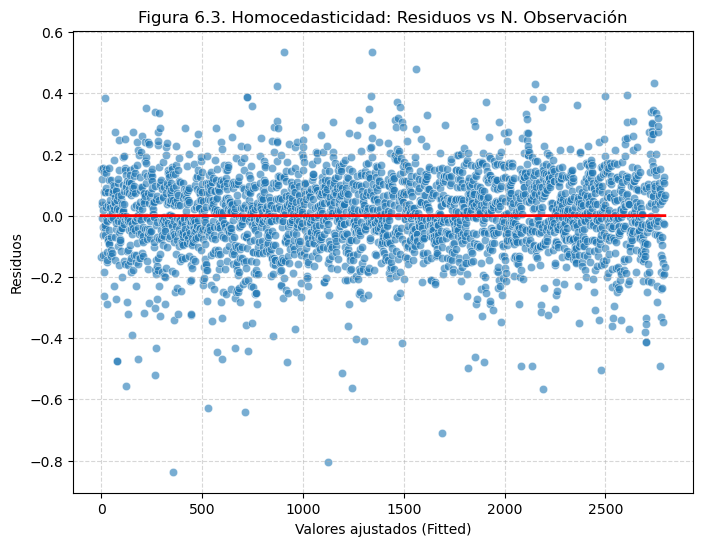

In [9]:
# Visualización: Residuos vs Valores ajustados
plt.figure(figsize=(8,6))
sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.6)
sns.lineplot(x=range(len(residuals)), y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Figura 6.3. Homocedasticidad: Residuos vs N. Observación')
plt.xlabel('Valores ajustados (Fitted)')
plt.ylabel('Residuos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Analizando los resultados, vemos que no se cumple el criterio de homocedasticidad. Observamos que la varianza de las observaciones no es homogenea a lo largo de las observaciones obtenidas. El uso de metodos más robustos en el siguiente capítulo nos dará una solución a este problema.

## 6.5 Validación de Supuesto de Normalidad (QQ-plot)

Para evualuar normalidad, hacemos un QQ-plot, donde esperamos que la frecuencia de los residuos se alinea a la esperada cuando se cumple la normalidad.

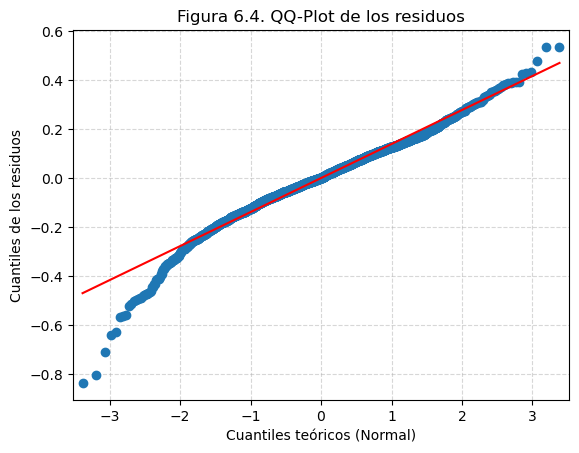

In [10]:
# QQ Plot para evaluar normalidad
sm.qqplot(residuals, line='s', color='blue')
plt.title("Figura 6.4. QQ-Plot de los residuos")
plt.xlabel("Cuantiles teóricos (Normal)")
plt.ylabel("Cuantiles de los residuos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Observando la **Figura 6.4**, vemos que la normalidad se cumple en una gran parte de los cuantiles, con excepción de los extremos, donde vemos que la frecuencia obtenida es distinta de lo esperado. Esto podría deberse a datos atípico que no fueron eliminados correctamente o a la presencia de observacioens que el modelo falló en interpretar correctamente.

## 6.6 Validación de supuesto de autocorrelación

La autocorrelación ocurre cuando los residuos de un modelo de regresión no son independientes entre sí, es decir, cuando el error en una observación está relacionado con el error en otra.

Para validar este supuesto, usamos el metodo de Durbin-Watson, el cual nos entrega un estadístico que nos permite validar la presencia de autocorrelación positiva o negativa.

En nuestro modelo obtuvimos un valor de Durbin-Watson de 1.69, lo que nos permite descartar la presencia de autocorrelación en nuestros resultados.


Estadístico de Durbin–Watson: 1.6967
No hay evidencia fuerte de autocorrelación (residuos independientes).


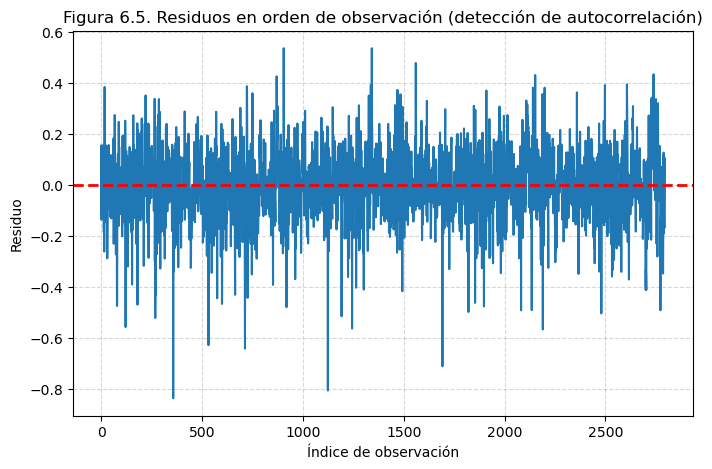

In [11]:
# =============================
# 4. Calcular estadístico de Durbin–Watson
# =============================
dw_stat = durbin_watson(residuals)
print(f"\nEstadístico de Durbin–Watson: {dw_stat:.4f}")

# =============================
# 5. Interpretación
# =============================
if dw_stat < 1.5:
    print("Posible autocorrelación positiva de los residuos.")
elif dw_stat > 2.5:
    print("Posible autocorrelación negativa de los residuos.")
else:
    print("No hay evidencia fuerte de autocorrelación (residuos independientes).")


# Visualización: residuos vs índice (orden de observación)
plt.figure(figsize=(8,5))
sns.lineplot(x=range(len(residuals)), y=residuals)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("Figura 6.5. Residuos en orden de observación (detección de autocorrelación)")
plt.xlabel("Índice de observación")
plt.ylabel("Residuo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 6.7 Validación de multicolinealidad

La multicolinealidad ocurre cuando dos o más variables explicativas (predictoras) en un modelo de regresión están altamente correlacionadas entre sí.  
En otras palabras, una variable puede explicarse linealmente a partir de otra (o de un conjunto de otras variables).

Esto genera redundancia en la información: el modelo no puede distinguir claramente el efecto individual de cada predictor sobre la variable dependiente.

In [12]:
vif_data = pd.DataFrame()
vif_data["Variable"] = ['const'] + regressor_columns_def
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print("\nFactores de inflación de la varianza (VIF):")
print(vif_data)

# =============================
# 3. Interpretación
# =============================
print("\nInterpretación:")
for var, vif in zip(vif_data["Variable"], vif_data["VIF"]):
    if vif < 5:
        print(f"{var}: Sin multicolinealidad significativa (VIF={vif:.2f})")
    elif vif < 10:
        print(f"{var}: Multicolinealidad moderada (VIF={vif:.2f})")
    else:
        print(f"{var}: Alta multicolinealidad (VIF={vif:.2f}) — considerar eliminar o combinar variables.")


Factores de inflación de la varianza (VIF):
                      Variable           VIF
0                        const  26707.188562
1                 Overall Qual      2.838031
2                  Gr Liv Area      2.504488
3                  Garage Area      1.742307
4                   Year Built      3.453355
5                   1st Flr SF      1.495237
6                Exter Qual_TA      9.263417
7               Year Remod/Add      2.159563
8                    Full Bath      2.150712
9                Garage Yr Blt      3.365818
10             Kitchen Qual_TA      2.091199
11  Fireplace Qu_Sin categoria      1.386612
12               Exter Qual_Gd      7.692137

Interpretación:
const: Alta multicolinealidad (VIF=26707.19) — considerar eliminar o combinar variables.
Overall Qual: Sin multicolinealidad significativa (VIF=2.84)
Gr Liv Area: Sin multicolinealidad significativa (VIF=2.50)
Garage Area: Sin multicolinealidad significativa (VIF=1.74)
Year Built: Sin multicolinealidad sign

---
Analizando nuestro dataset, encontramos multicolinealidad en las columnas Exter Qual_TA y Exter Qual_Gd, lo cual tiene sentido ya que son columnas one-hot-encoding que parten de la misma columna, y que toman valores de acuerdo a la categoría original representada. Para solventar esta multicolinealidad, combinamos ambas columnas en una, ya que si hay una relación de ordinalidad entre diferentes categorías: Tiene sentido que una casa con exterior bueno rankee más alto que una con exterior sencillo.

In [66]:
regressors = vif_data[vif_data["VIF"] < 5]["Variable"].tolist()

regressors

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Year Built',
 '1st Flr SF',
 'Year Remod/Add',
 'Full Bath',
 'Garage Yr Blt',
 'Kitchen Qual_TA',
 'Fireplace Qu_Sin categoria']

In [67]:
exterqual_map = {
    'Po': 1,   # Poor
    'Fa': 2,   # Fair
    'TA': 3,   # Typical/Average
    'Gd': 4,   # Good
    'Ex': 5    # Excellent
}

df['Exter Qual'] = df_original['Exter Qual'].map(exterqual_map)

df

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Year Built,1st Flr SF,Exter Qual_TA,Year Remod/Add,Full Bath,Foundation_PConc,Garage Yr Blt,Kitchen Qual_TA,Fireplace Qu_Sin categoria,Exter Qual_Gd,Exter Qual
0,12.278398,6,7.412764,2.0,528.0,1960,7.412764,1.0,1960,1,0.0,1960.0,1.0,0.0,0.0,3
1,11.561725,5,6.799056,1.0,730.0,1961,6.799056,1.0,1961,1,0.0,1961.0,1.0,1.0,0.0,3
2,12.055256,6,7.192934,1.0,312.0,1958,7.192934,1.0,1958,1,0.0,1958.0,0.0,1.0,0.0,3
3,12.404928,7,7.654917,2.0,522.0,1968,7.654917,0.0,1968,2,0.0,1968.0,0.0,0.0,1.0,4
4,12.154258,5,7.396335,2.0,482.0,1997,6.834109,1.0,1998,2,1.0,1997.0,1.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,11.867104,6,6.911747,2.0,588.0,1984,6.911747,1.0,1984,1,0.0,1984.0,1.0,1.0,0.0,3
2792,11.782960,5,6.805723,2.0,484.0,1983,6.805723,1.0,1983,1,0.0,1983.0,1.0,1.0,0.0,4
2793,11.790565,5,6.878326,0.0,0.0,1992,6.878326,1.0,1992,1,1.0,1979.0,1.0,1.0,0.0,4
2794,12.043560,5,7.237059,2.0,418.0,1974,7.237059,1.0,1975,1,0.0,1975.0,1.0,0.0,0.0,4


---
Calculamos nuevamente nuestro modelo con la nueva columna

In [68]:
regressors.append('Exter Qual')
X2 = df[regressors].to_numpy()

## inserción de 1
X_1 = np.insert(X2, obj=0, values=1, axis=1)

X_1

array([[1.        , 6.        , 7.41276402, ..., 1.        , 0.        ,
        3.        ],
       [1.        , 5.        , 6.79905586, ..., 1.        , 1.        ,
        3.        ],
       [1.        , 6.        , 7.19293422, ..., 0.        , 1.        ,
        3.        ],
       ...,
       [1.        , 5.        , 6.87832647, ..., 1.        , 1.        ,
        4.        ],
       [1.        , 5.        , 7.23705903, ..., 1.        , 0.        ,
        4.        ],
       [1.        , 7.        , 7.60140233, ..., 1.        , 0.        ,
        4.        ]], shape=(2796, 12))

In [69]:
model = OLS(Y,X_1)
result = model.fit()

result.params

array([-1.04293507e-01,  8.47052651e-02,  3.54485012e-01,  2.56543756e-04,
        2.38547022e-03,  1.85063029e-01,  2.22750981e-03, -3.39681206e-02,
       -7.10606882e-04, -3.33814599e-02, -7.04591376e-02,  2.41983153e-03])

In [70]:
X_1.shape

(2796, 12)

In [71]:
vif_data2 = pd.DataFrame()
vif_data2["Variable"] = ['const'] + regressors
vif_data2["VIF"] = [variance_inflation_factor(X_1, i) for i in range(X_1.shape[1])]

print("\nFactores de inflación de la varianza (VIF):")
print(vif_data2)

# =============================
# 3. Interpretación
# =============================
print("\nInterpretación:")
for var, vif in zip(vif_data2["Variable"], vif_data2["VIF"]):
    if vif < 5:
        print(f"{var}: Sin multicolinealidad significativa (VIF={vif:.2f})")
    elif vif < 10:
        print(f"{var}: Multicolinealidad moderada (VIF={vif:.2f})")
    else:
        print(f"{var}: Alta multicolinealidad (VIF={vif:.2f}) — considerar eliminar o combinar variables.")


Factores de inflación de la varianza (VIF):
                      Variable           VIF
0                        const  24806.009872
1                 Overall Qual      2.585581
2                  Gr Liv Area      2.499769
3                  Garage Area      1.741816
4                   Year Built      3.395478
5                   1st Flr SF      1.478642
6               Year Remod/Add      2.152652
7                    Full Bath      2.148916
8                Garage Yr Blt      3.285248
9              Kitchen Qual_TA      1.775390
10  Fireplace Qu_Sin categoria      1.384321
11                  Exter Qual      1.039498

Interpretación:
const: Alta multicolinealidad (VIF=24806.01) — considerar eliminar o combinar variables.
Overall Qual: Sin multicolinealidad significativa (VIF=2.59)
Gr Liv Area: Sin multicolinealidad significativa (VIF=2.50)
Garage Area: Sin multicolinealidad significativa (VIF=1.74)
Year Built: Sin multicolinealidad significativa (VIF=3.40)
1st Flr SF: Sin multicol

---
Observamos entonces que la multicolinealidad es eliminada con exito. Finalmente, volvemos a analizar los estadísticos de nuestro modelo.

In [72]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1458.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:37:10   Log-Likelihood:                 1543.4
No. Observations:                2796   AIC:                            -3063.
Df Residuals:                    2784   BIC:                            -2991.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1043      0.416     -0.251      0.802      -0.920       0.711
x1             0.0847      0.003     26.104      0.000       0.078       0.091
x2             0.3545      0.014     25.591      0.000       0.327       0.382
x3             0.0003   1.78e-05     14.417      0.000       0.000       0.000
x4             0.0024      0.000     14.393      0.000       0.002       0.003
x5             0.1851      0.011     17.583      0.000       0.164       0.206
x6             0.0022      0.000     11.892      0.000       0.002       0.003
x7            -0.0340      0.007     -4.695      0.000      -0.048      -0.020
x8            -0.0007      0.000     -3.563      0.000      -0.001      -0.000
x9            -0.0334      0.007     -4.741      0.000      -0.047      -0.020
x10           -0.0705      0.006    -11.337      0.000      -0.083      -0.058
x11            0.0024      0.005      0.525      0.600      -0.007       0.011
==============================================================================
Omnibus:                      264.210   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              721.954
Skew:                          -0.520   Prob(JB):                    1.70e-157
Kurtosis:                       5.262   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observamos que la nueva columna no parece tener una gran significancia en la explicación de Y, por lo que procedemos a elimarla y calcular nuevamente nuestro modelo.

In [73]:
regressors.remove('Exter Qual')

In [74]:
print(regressors)

['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Year Built', '1st Flr SF', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Kitchen Qual_TA', 'Fireplace Qu_Sin categoria']


In [81]:
X3 = df[regressors].to_numpy()

## inserción de 1
X3 = np.insert(X3, obj=0, values=1, axis=1)

X3

array([[1.00000000e+00, 6.00000000e+00, 7.41276402e+00, ...,
        1.96000000e+03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.00000000e+00, 6.79905586e+00, ...,
        1.96100000e+03, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 6.00000000e+00, 7.19293422e+00, ...,
        1.95800000e+03, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+00, 5.00000000e+00, 6.87832647e+00, ...,
        1.97900000e+03, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 5.00000000e+00, 7.23705903e+00, ...,
        1.97500000e+03, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 7.00000000e+00, 7.60140233e+00, ...,
        1.99300000e+03, 1.00000000e+00, 0.00000000e+00]], shape=(2796, 11))

In [82]:
model = OLS(Y,X3)
result = model.fit()

result.params

array([-1.00081025e-01,  8.48254527e-02,  3.54140486e-01,  2.56573512e-04,
        2.38877708e-03,  1.85190585e-01,  2.22483607e-03, -3.38498128e-02,
       -7.08818106e-04, -3.34956337e-02, -7.04437725e-02])

In [83]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1604.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:39:31   Log-Likelihood:                 1543.2
No. Observations:                2796   AIC:                            -3064.
Df Residuals:                    2785   BIC:                            -2999.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1001      0.416     -0.241      0.810      -0.915       0.715
x1             0.0848      0.003     26.210      0.000       0.078       0.091
x2             0.3541      0.014     25.598      0.000       0.327       0.381
x3             0.0003   1.78e-05     14.421      0.000       0.000       0.000
x4             0.0024      0.000     14.425      0.000       0.002       0.003
x5             0.1852      0.011     17.602      0.000       0.165       0.206
x6             0.0022      0.000     11.883      0.000       0.002       0.003
x7            -0.0338      0.007     -4.681      0.000      -0.048      -0.020
x8            -0.0007      0.000     -3.555      0.000      -0.001      -0.000
x9            -0.0335      0.007     -4.760      0.000      -0.047      -0.020
x10           -0.0704      0.006    -11.336      0.000      -0.083      -0.058
==============================================================================
Omnibus:                      262.543   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.317
Skew:                          -0.518   Prob(JB):                    7.73e-156
Kurtosis:                       5.249   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
Finalmente, guardamos nuestro modelo para uso futuro

In [84]:
X3.dump('../Data/X_def2.dat')
result.params.dump('../Data/B_def2.dat')
Y.dump('../Data/Y_def2.dat')

In [85]:
result.save("../Data/ols_def2_results.pickle")

In [86]:
with open("../Data/regressor_columns_def2.pickle", "wb") as fp:   #Pickling
...   pickle.dump(regressors, fp)